In [10]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [11]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 9,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

In [12]:
def plot_series(series):
    plt.figure(figsize=(20, 6))
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='red')

In [13]:
df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)

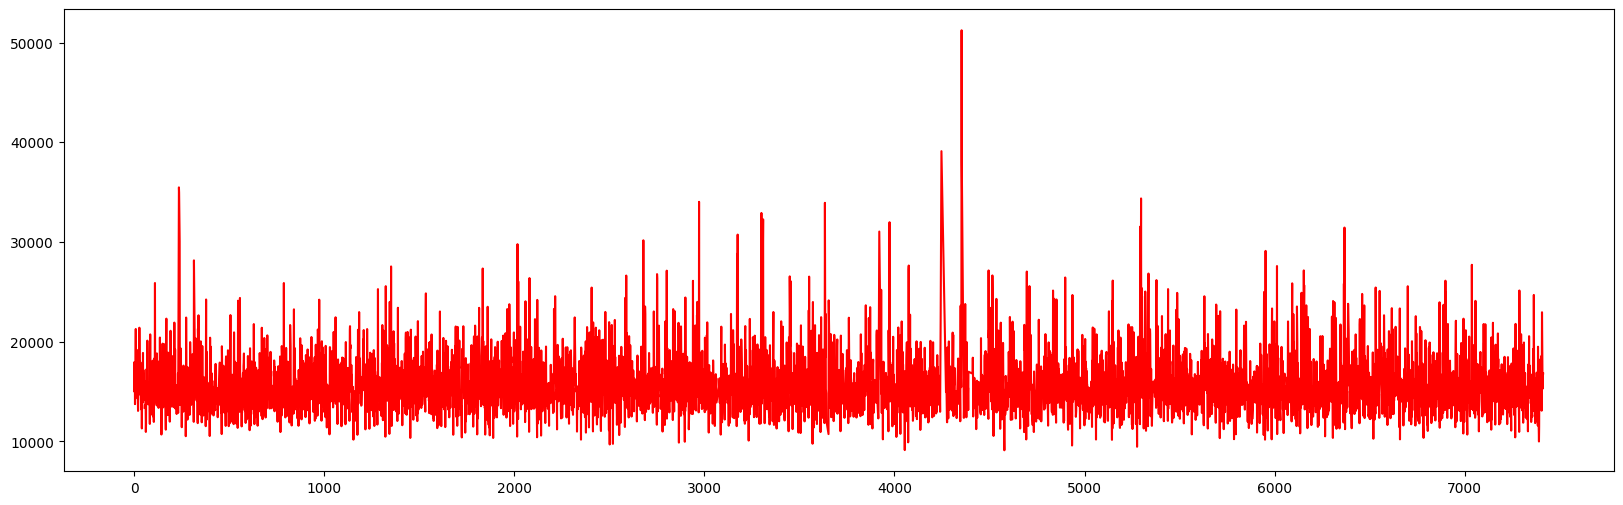

In [14]:
plot_series(df['delta_t'])
plt.show()

# Load data

In [15]:
def split_data_time_over(period, cfg):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    num_data_points = len(df)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)

    data_travel_time = [float(df.loc[df.index == date]['delta_t']) for date in df.index]
    data_travel_time = np.array(data_travel_time)

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        tmp_time = pd.Series(time[part_time_idx], name='datetime')
        tmp_travel_time = pd.Series(travel_time[part_time_idx], name='travel_time')
        df = pd.concat([tmp_time, tmp_travel_time], axis=1)
        df = df.set_index('datetime')

        num_data_points_list.append(len(df))
        df_list.append(df)

    return df_list, num_data_points_list

In [16]:
df, num_data_points_list = split_data_time_over(3, cfg)

# Data preparation: normalize raw data

In [17]:
# class Normalizer:
#     def __init__(self, min_v, max_v):
#         self.data = None
#         self.data_min = 0
#         self.data_max = 0
#         self.min = min_v
#         self.max = max_v

#     def fit_transform(self, data):
#         self.data = data

#         # first difference
#         diff_data = data.diff().fillna(data)

#         # normalize
#         self.data_min = diff_data.min(axis=0)
#         self.data_max = diff_data.max(axis=0)

#         normalize = ((diff_data - self.data_min) / (self.data_max - self.data_min)) * (self.max - self.min) + self.min

#         return normalize

#     def inverse_transform(self, data, split_data_index=0):
#         inverse_data = []
#         for idx in range(len(data)):
#             # check first data
#             if (idx + split_data_index) == 0:
#                 _data = ((data[idx] - self.min) / (self.max - self.min)) * (self.data_max - self.data_min) + self.data_min + self.data[0]
#             else:
#                 _data = ((data[idx] - self.min) / (self.max - self.min)) * (self.data_max - self.data_min) + self.data_min + self.data[(idx - 1) + split_data_index]
#             inverse_data.append(_data)

#         inverse_series = pd.Series(inverse_data, index=data.index)

#         return inverse_series

In [18]:
class Normalizer:
    def __init__(self):
        self.data = None
        self.std_diff = 0
        self.mean_diff = 0

    def fit_transform(self, data):
        self.data = data

        # first difference
        diff_data = data.diff().fillna(data)

        # normalize
        self.mean_diff, self.std_diff = diff_data.mean(), diff_data.std()
        normalize_data = (diff_data - self.mean_diff) / self.std_diff

        return normalize_data

    def inverse_transform(self, data, split_data_index=0):
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            if (idx + split_data_index) == 0:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[0]
            else:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[(idx - 1) + split_data_index]
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series

In [19]:
# class Normalizer:
#     def __init__(self):
#         self.normalize_data = None
#         self.std_data = 0
#         self.mean_data = 0
#         self.std_diff = None

#     def fit_transform(self, data):
#         # normalize
#         self.mean_data, self.std_data = data.mean(), data.std()
#         self.normalize_data = (data - self.mean_data) / self.std_data
        
#         # first difference
#         diff_data = self.normalize_data.diff().fillna(self.normalize_data)
#         # diff_data = self.normalize_data.diff().dropna()
        
#         # remove increasing volatility
#         self.std_diff = diff_data.groupby(diff_data.index.hour).std()
#         data_hourly_volatility = diff_data.index.map(lambda d: self.std_diff.loc[d.hour])

#         remove_data = diff_data / data_hourly_volatility

#         return remove_data

#     def inverse_transform(self, data, split_data_index=0):
#         inverse_data = []
#         for idx in range(len(data)):
#             # check first data
#             if (idx + split_data_index) == 0:
#                 _data = (self.std_data * (self.std_diff[data.index[idx].hour] * data[idx])) + self.mean_data
#             else:
#                 _data = (self.std_data * ((self.std_diff[data.index[idx].hour] * data[idx]) + self.normalize_data[(idx - 1) + split_data_index])) + self.mean_data
#             inverse_data.append(_data)

#         inverse_series = pd.Series(inverse_data, index=data.index)

#         return inverse_series

In [20]:
scaler_list = [Normalizer() for _ in range(len(df))]
normalize_data_list = [scaler_list[idx].fit_transform(df[idx]['travel_time']) for idx in range(len(df))]

# Data preparation: generating training, test and validation data

In [21]:
def preprocess(data, window_size):
    X, y, y_date = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i].to_list())
        y.append(data[i])
        y_date.append(data.index[i])
    return np.array(X), np.array(y), np.array(y_date)

def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
    data_x, data_y, data_date_y = preprocess(normalize_data, cfg['data']['window_size'])
    
    # init split index
    split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data x
    data_x_train = data_x[:split_train_index]
    data_x_val = data_x[split_train_index:split_val_index]
    data_x_test = data_x[split_val_index:]

    # split data y
    data_y_train = data_y[:split_train_index]
    data_date_y_train = data_date_y[:split_train_index]
    data_y_val = data_y[split_train_index:split_val_index]
    data_date_y_val = data_date_y[split_train_index:split_val_index]
    data_y_test = data_y[split_val_index:]
    data_date_y_test = data_date_y[split_val_index:]

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)
        

        data_y_train_series = pd.Series(data_y_train, index=data_date_y_train)
        data_y_val_series = pd.Series(data_y_val, index=data_date_y_val)
        data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)


        to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train_series, cfg['data']['window_size'])
        to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val_series, split_train_index + cfg['data']['window_size'])
        to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, split_val_index + cfg['data']['window_size'])

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        idx = np.arange(0, len(normalize_data))

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(idx, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, split_train_index, split_val_index


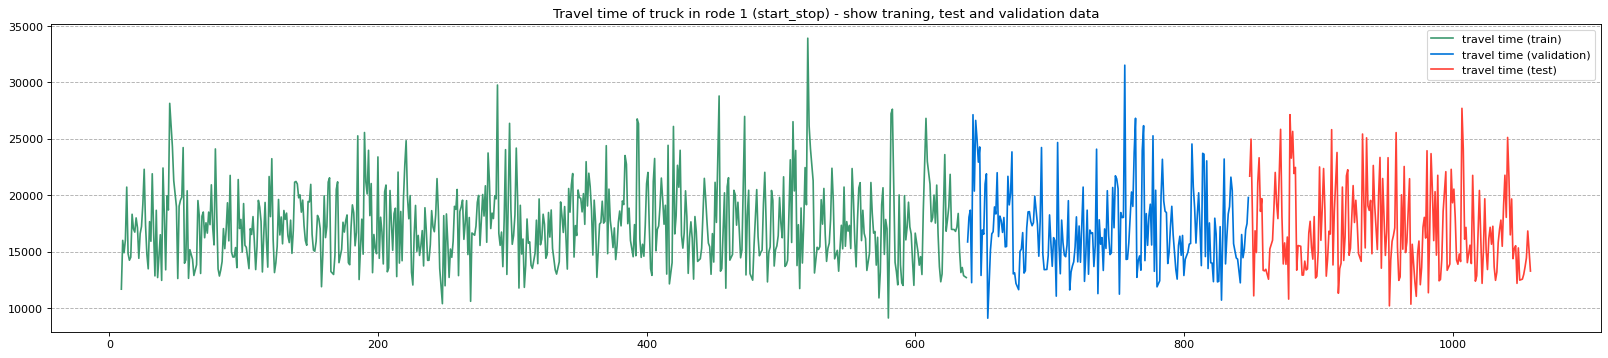

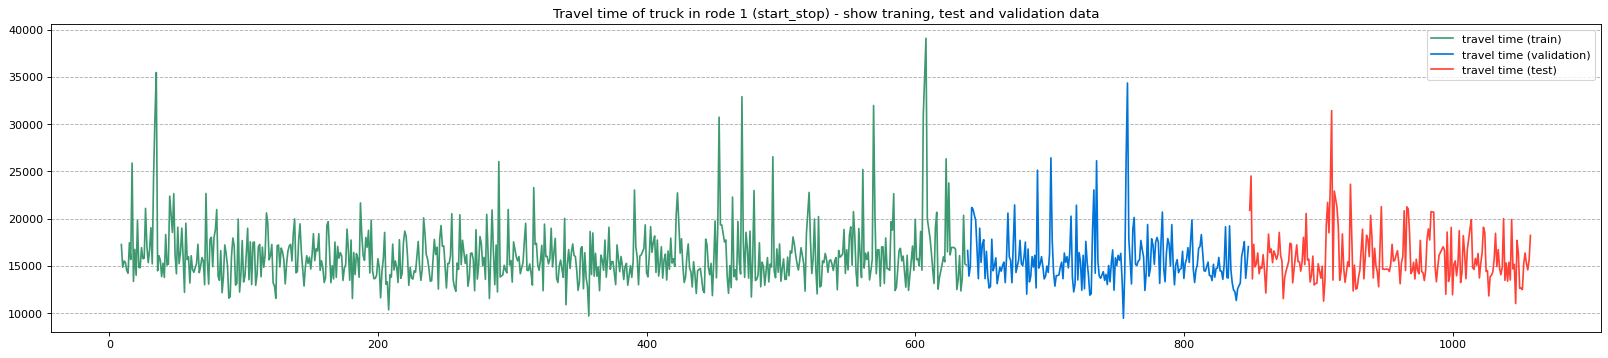

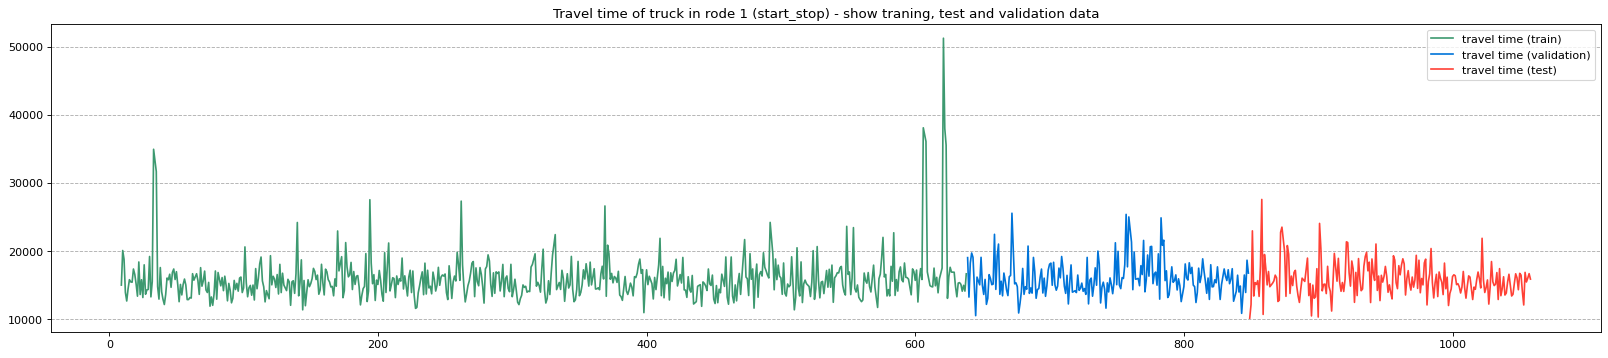

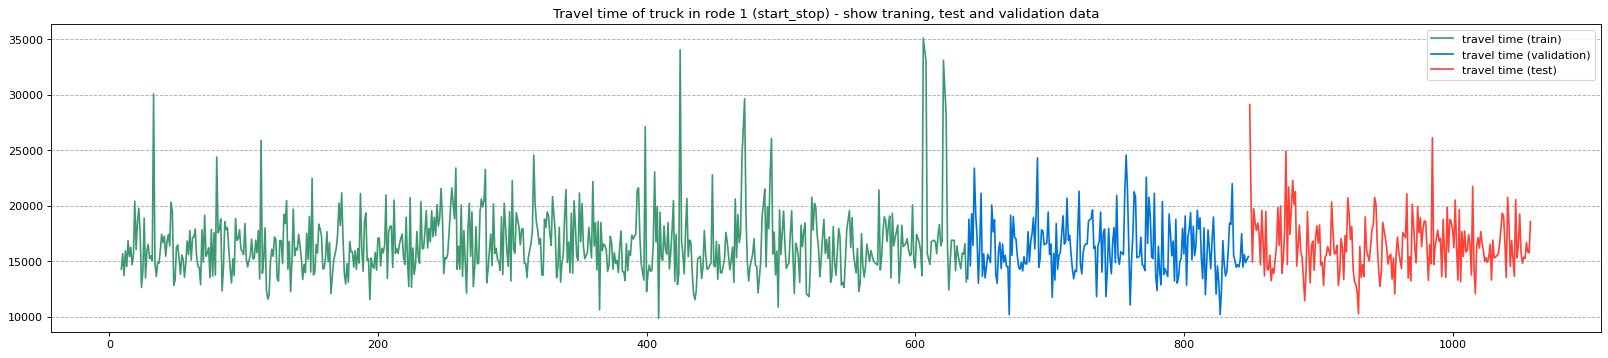

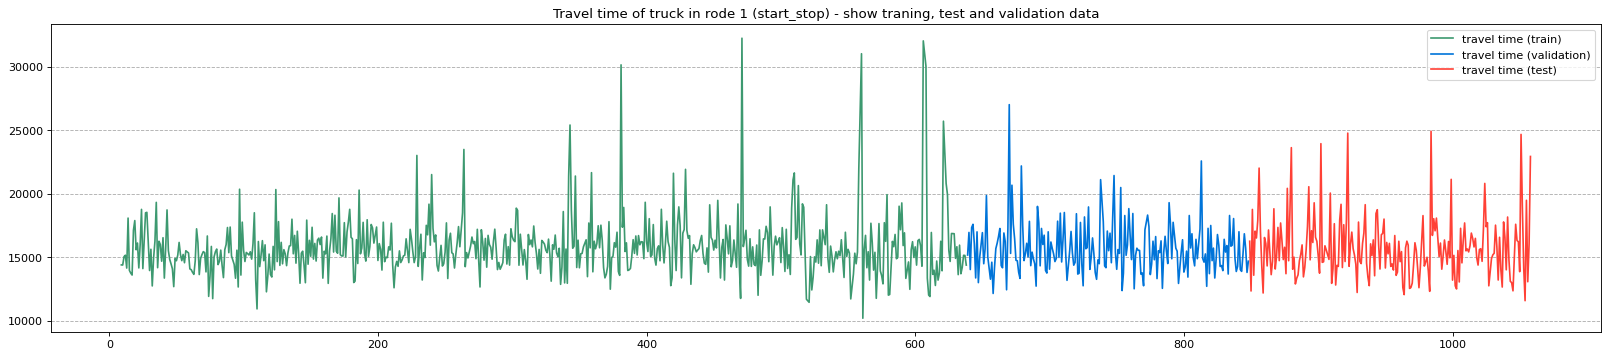

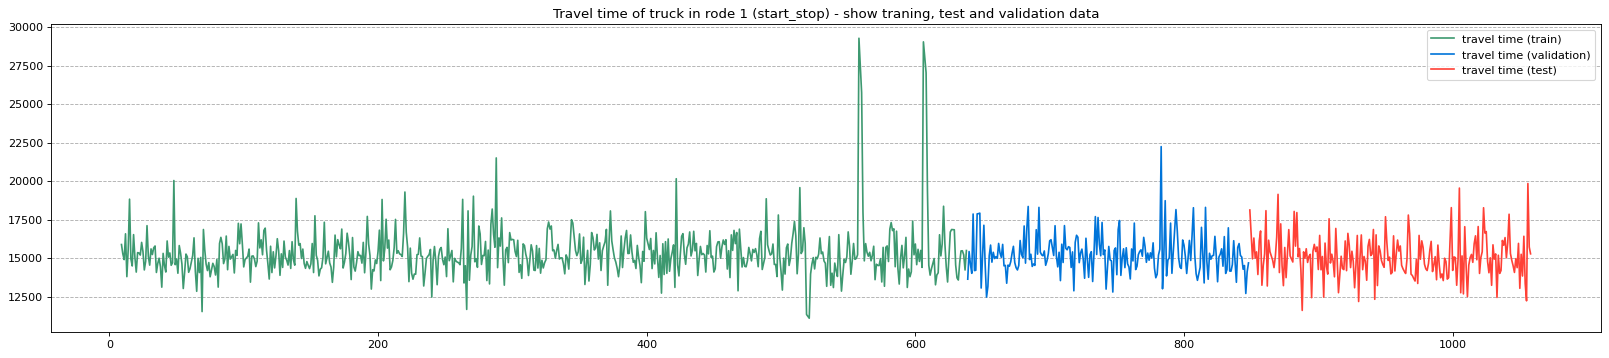

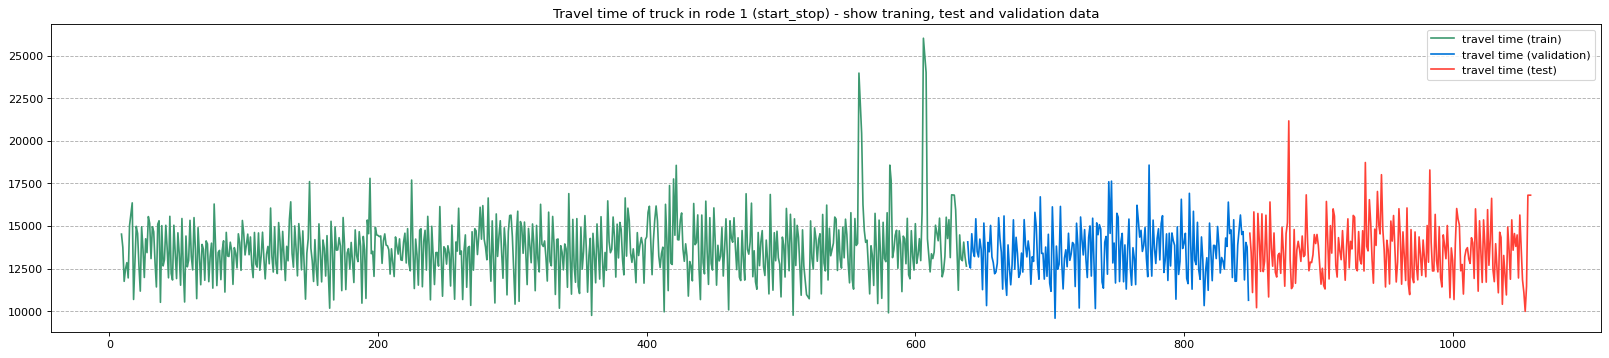

In [22]:
data_x_train_list, data_x_val_list, data_x_test_list, data_y_train_list, data_y_val_list, data_y_test_list, data_date_y_test_list, split_val_index_list = [], [], [], [], [], [], [], []
for idx in range(len(normalize_data_list)):
    data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, _, split_val_index = generate_train_test_val(normalize_data_list[idx], num_data_points_list[idx], scaler_list[idx], cfg, True)
    data_x_train_list.append(data_x_train)
    data_x_val_list.append(data_x_val)
    data_x_test_list.append(data_x_test)
    data_y_train_list.append(data_y_train)
    data_y_val_list.append(data_y_val)
    data_y_test_list.append(data_y_test)
    data_date_y_test_list.append(data_date_y_test)
    split_val_index_list.append(split_val_index)

In [23]:
# def plot_series(series):
#     plt.figure(figsize=(20, 6))
#     idx = np.arange(0, len(series))
#     plt.plot(idx, series, color='red')

In [24]:
# plot_series(data_y_train)
# plt.axhline(0, linestyle='--', color='k', alpha=0.3)
# plt.show()

In [25]:
for idx in range(len(data_x_train_list)):
    print(f"time: {idx}")
    print(f"Train data shape: {data_x_train_list[idx].shape} {data_y_train_list[idx].shape}")
    print(f"Validation data shape: {data_x_val_list[idx].shape} {data_y_val_list[idx].shape}")
    print(f"Test data shape: {data_x_test_list[idx].shape} {data_y_test_list[idx].shape}")

time: 0
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 1
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 2
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 3
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 4
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 5
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 6
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)


In [26]:
dataset_train, dataset_val, dataset_test = [], [], []
for idx in range(len(data_x_train_list)):
    dataset_train.append(TravelTimeDataset(data_x_train_list[idx], data_y_train_list[idx]))
    dataset_val.append(TravelTimeDataset(data_x_val_list[idx], data_y_val_list[idx]))
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Train data for model shape: {dataset_train[idx].x.shape} {dataset_train[idx].y.shape}")
    print(f"Validation data for model shape: {dataset_val[idx].x.shape} {dataset_val[idx].y.shape}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 1
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 2
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 3
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 4
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 5
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 6
Train data for model shape: (630, 1, 9) (630,)
Validation data for 

# Define CNN-LSTM model

In [27]:
class CNN_Block(nn.Module):
    def __init__(self):
        super(CNN_Block, self).__init__()
        self.conv_1_out = [32, 64, 128]
        self.conv_2_out = [32, 64, 128]
        self.conv_kernel_size = [2, 3]

        self.conv_1 = nn.Conv1d(1, 32, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_2 = nn.Conv1d(32, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_3 = nn.Conv1d(16, 16, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_4 = nn.Conv1d(16, 16, kernel_size=self.conv_kernel_size[0], stride=1)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        # out = F.relu(self.conv_3(out))
        # out = F.relu(self.conv_4(out))
        # out = self.maxpool_1(out)

        # out = self.conv_1(x)

        return out

In [28]:
class LSTM_Block(nn.Module):
    def __init__(self):
        super(LSTM_Block, self).__init__()
        self.lstm_in = [32, 64, 128]
        self.lstm_hidden = [64, 128, 200, 256]
        self.linear_out = [32, 64]
        self.dropout = [0.1, 0.2, 0.3]

        self.lstm_1 = nn.LSTM(
            input_size=64,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(64, 32)
        self.dropout_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(16, 8)

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out[:, -1, :]
        out = F.relu(self.fc_1(out))
        out = self.dropout_1(out)
        # out = F.relu(self.fc_2(out))

        return out

In [29]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.linear_in = [32, 64]
        self.cnn_block = CNN_Block()
        self.lstm_block = LSTM_Block()
        self.out_block = nn.Linear(32, 1)

    def forward(self, x):
        # CNN block
        out = self.cnn_block(x)

        # print(out.shape)

        out = out.view(out.shape[0], out.shape[2], out.shape[1])

        # print(out.shape)
        # LSTM block
        out = self.lstm_block(out)
        
        # Output layer
        out = self.out_block(out)

        return out

In [30]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [31]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model training

In [32]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=cfg['optimizer']['lr'])
    # optimizer = optim.Adadelta(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

# Model evaluation

In [33]:
def eval(dataset_test, data_date_y_test, split_val_index, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    data_test_y_series = pd.Series(dataset_test.y, index=data_date_y_test)
    predict_test_series = pd.Series(predicted_test, index=data_date_y_test)


    mse = mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    mae = mean_absolute_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))


    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size'])
        to_plot_predicted_test = scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])

        idx = np.arange(0, len(predict_test_series[:]))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, data_test_y_series, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, predict_test_series, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset[:], label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test[:], label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

# Modified

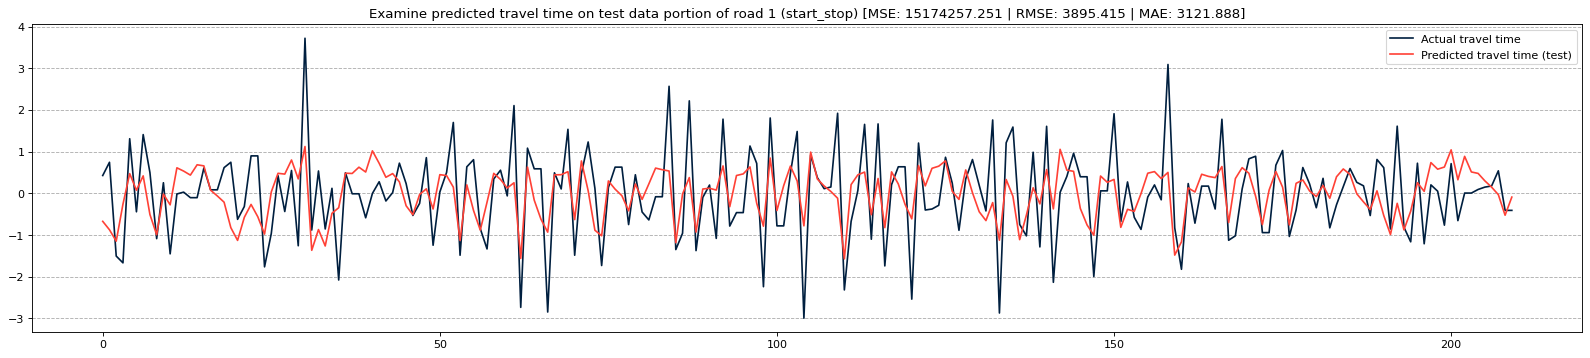

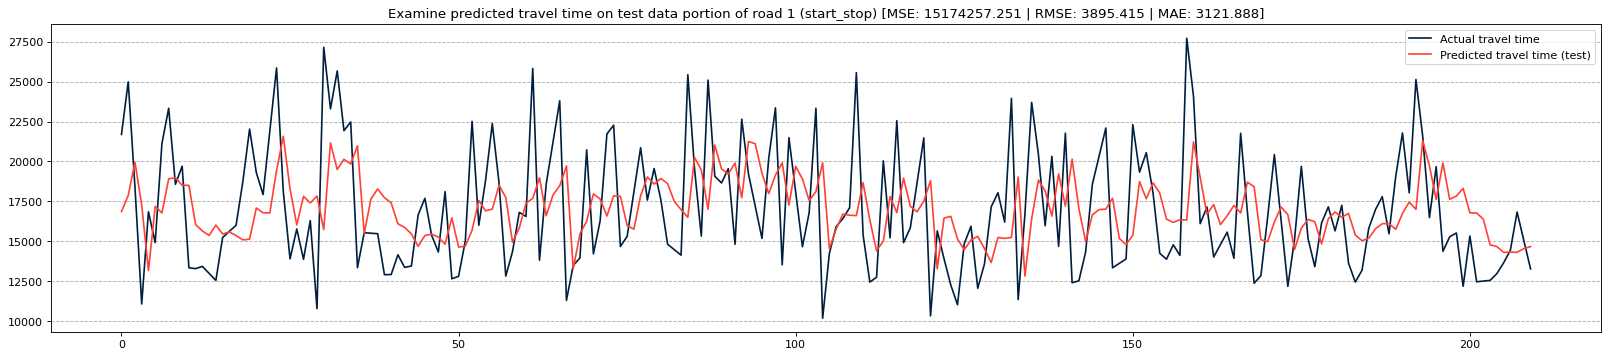

time : 0
MSE : 15174257.251480721 || RMSE : 3895.414901070324 || MAE : 3121.8876596895257


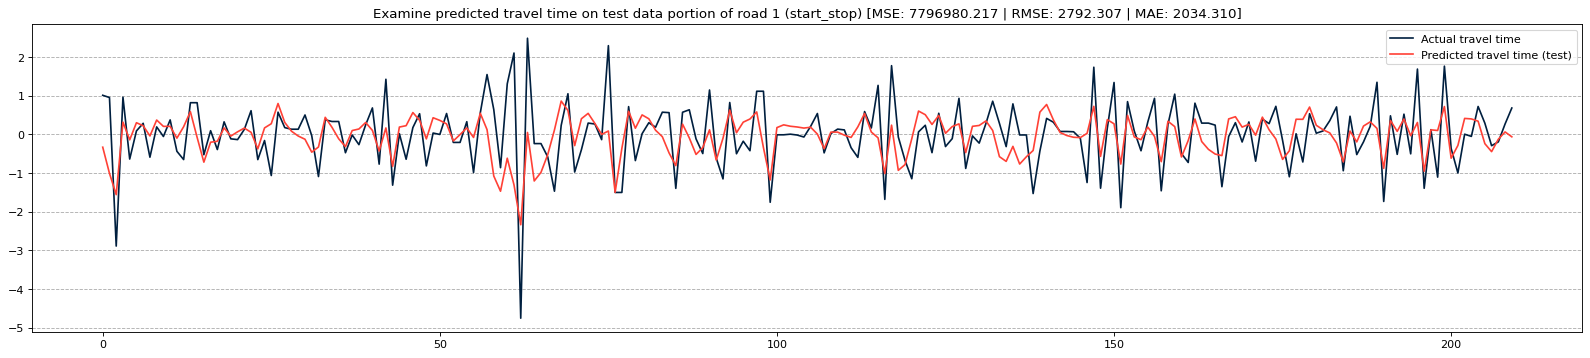

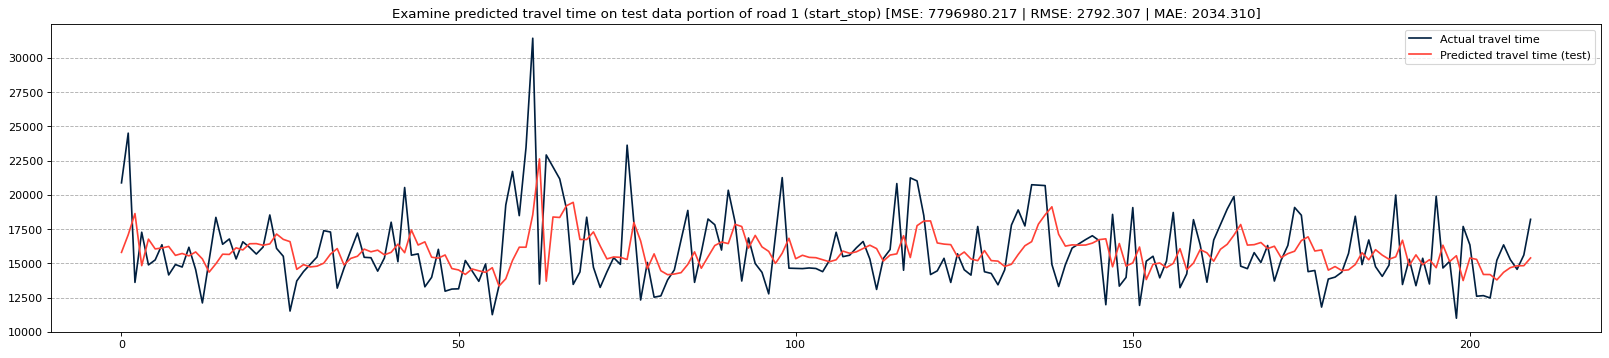

time : 1
MSE : 7796980.21666743 || RMSE : 2792.3073284771913 || MAE : 2034.3103286740227


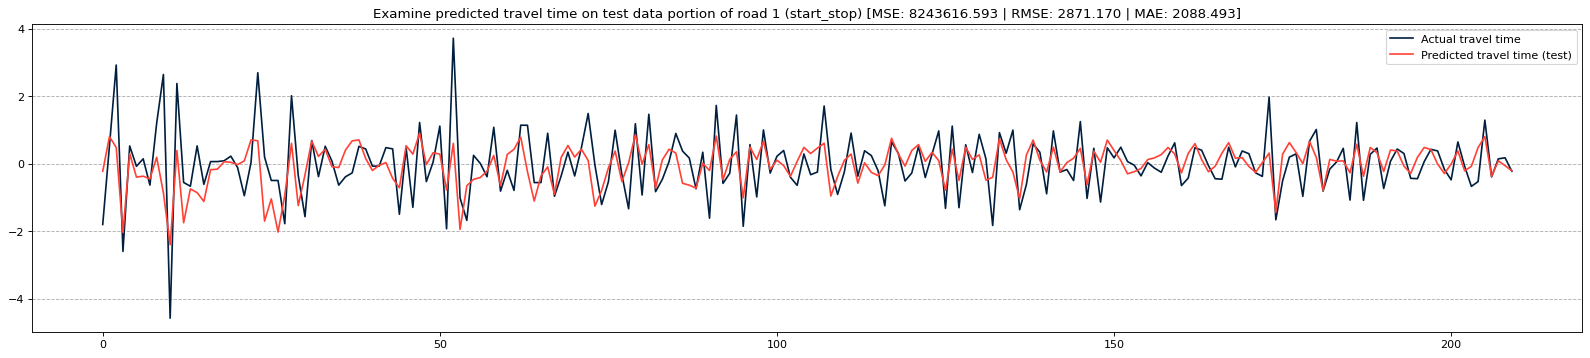

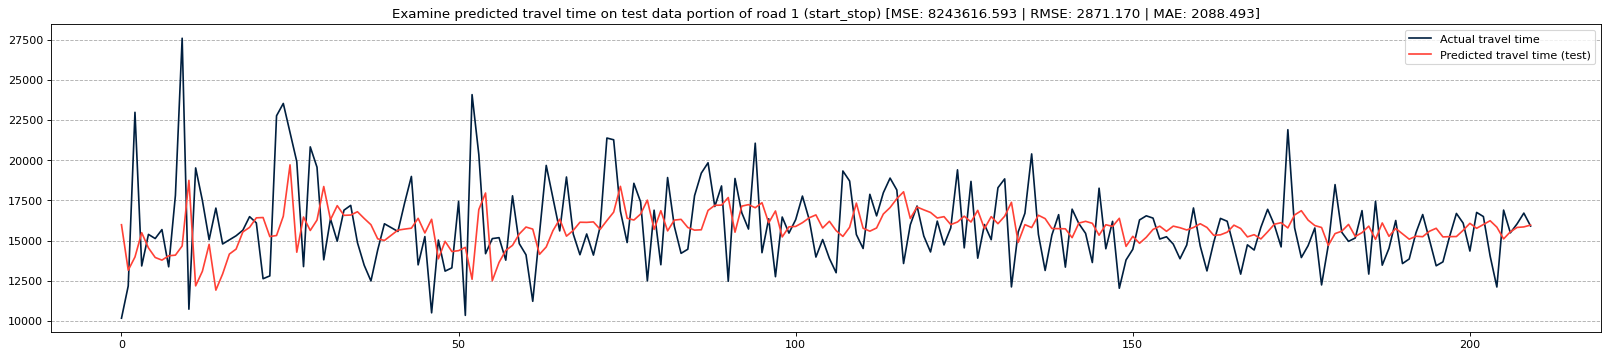

time : 2
MSE : 8243616.593232087 || RMSE : 2871.1698997502895 || MAE : 2088.4925214644304


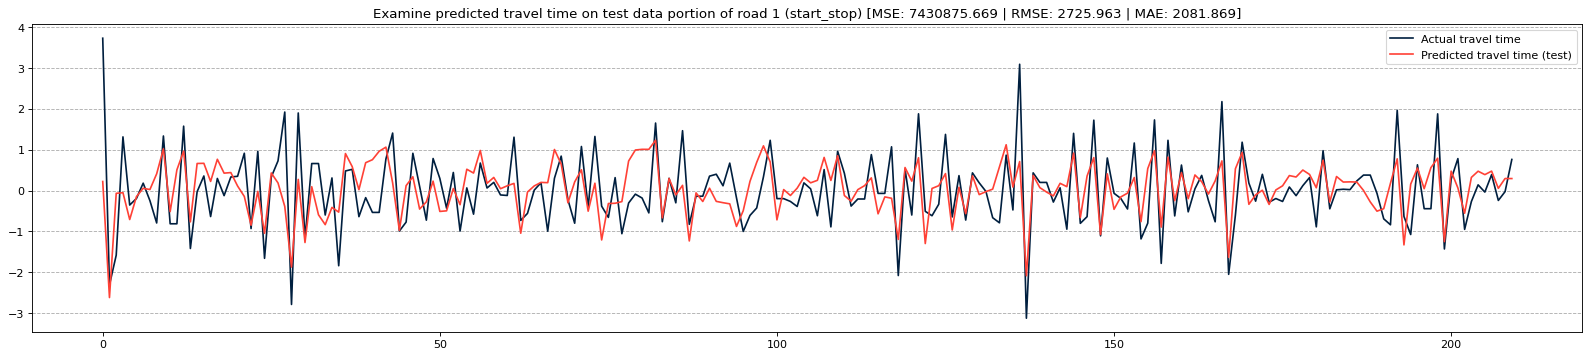

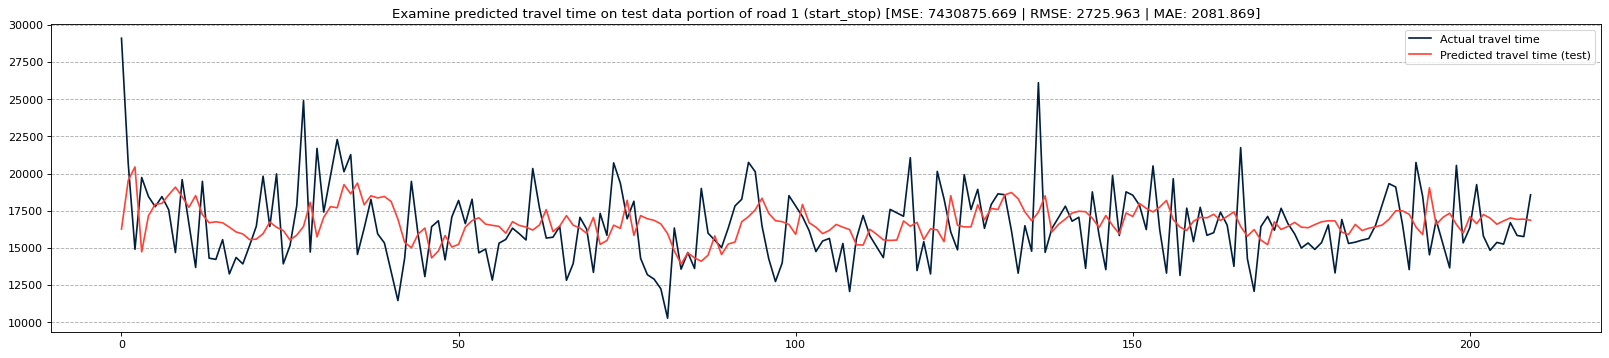

time : 3
MSE : 7430875.668661931 || RMSE : 2725.9632551929108 || MAE : 2081.869246288157


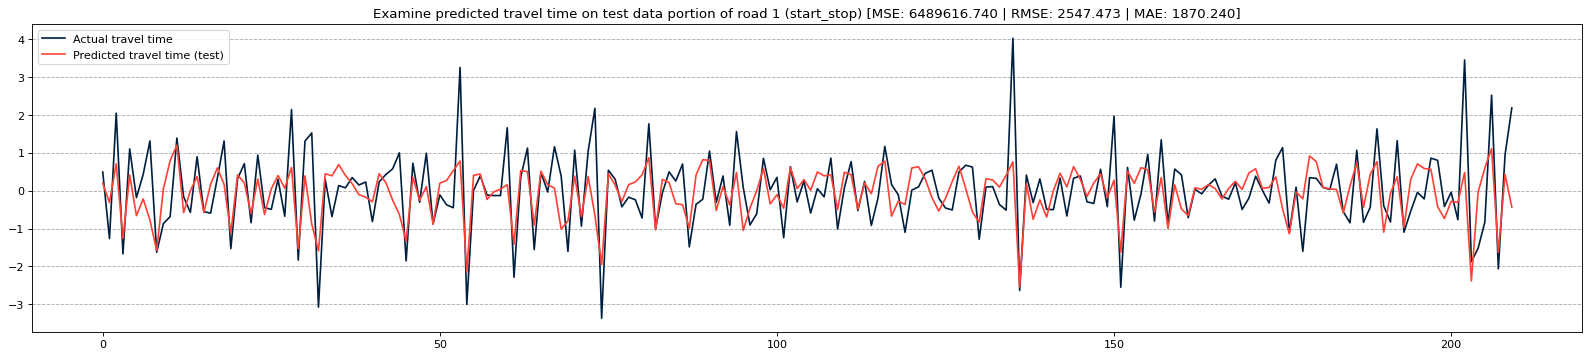

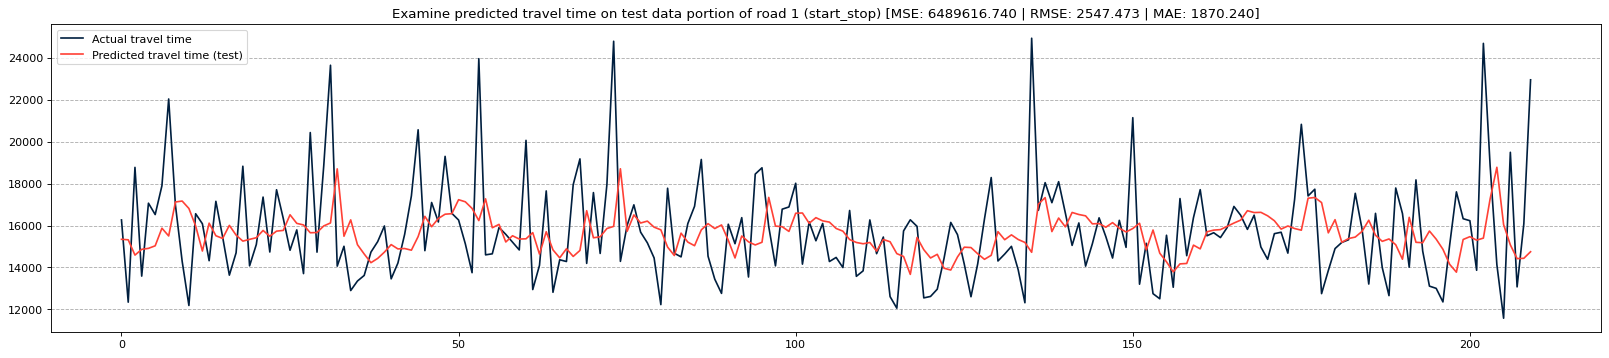

time : 4
MSE : 6489616.739696548 || RMSE : 2547.4726180464722 || MAE : 1870.239671614365


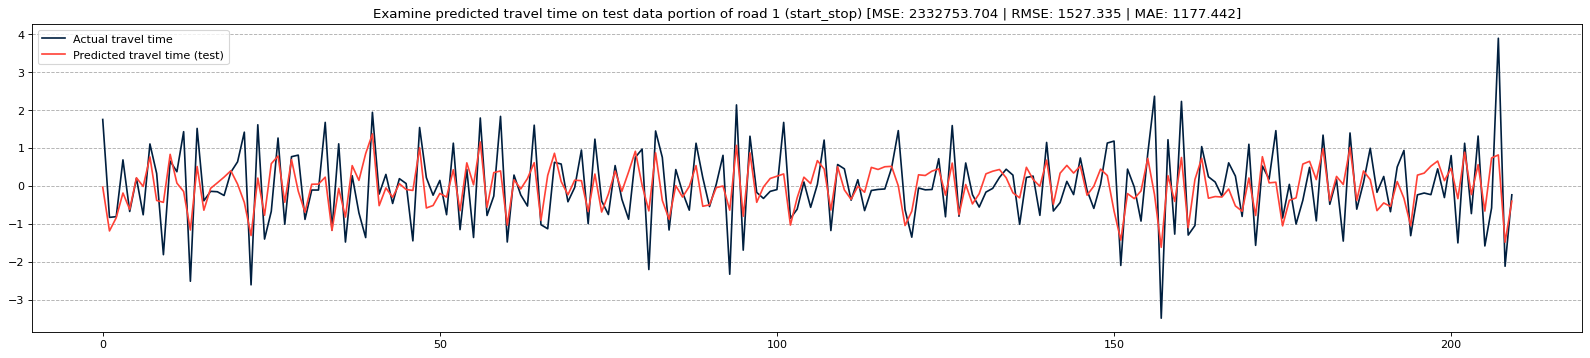

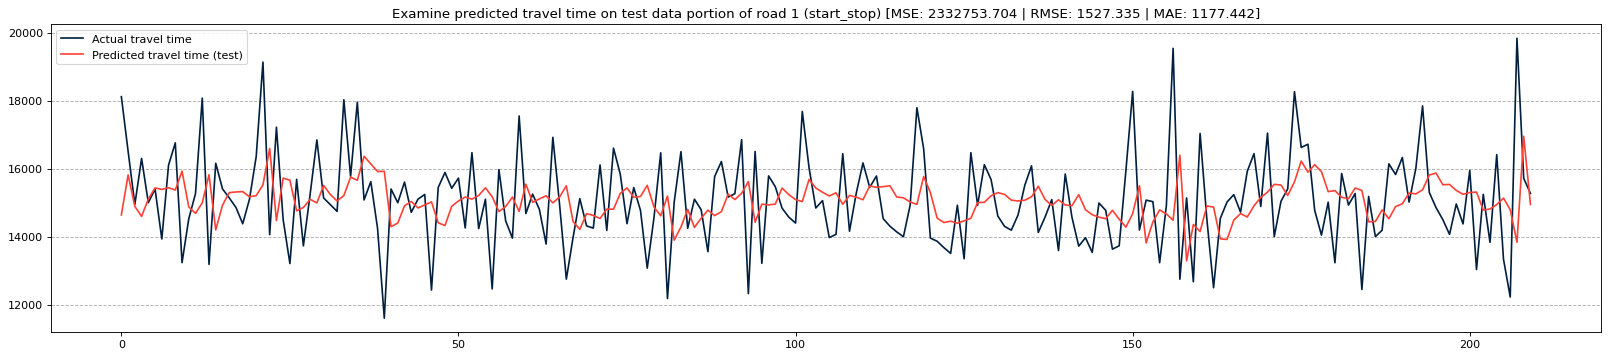

time : 5
MSE : 2332753.703798117 || RMSE : 1527.335491566315 || MAE : 1177.441591703443


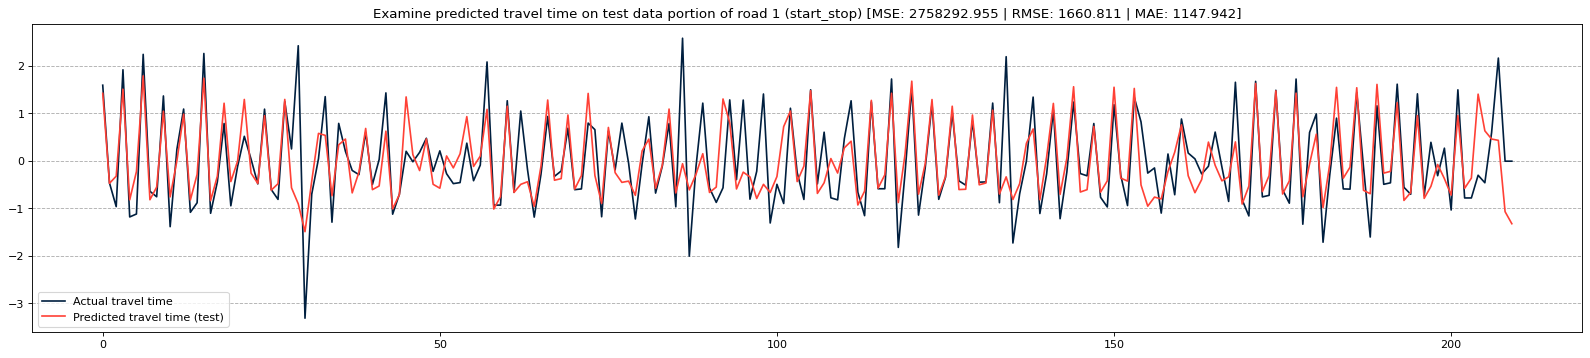

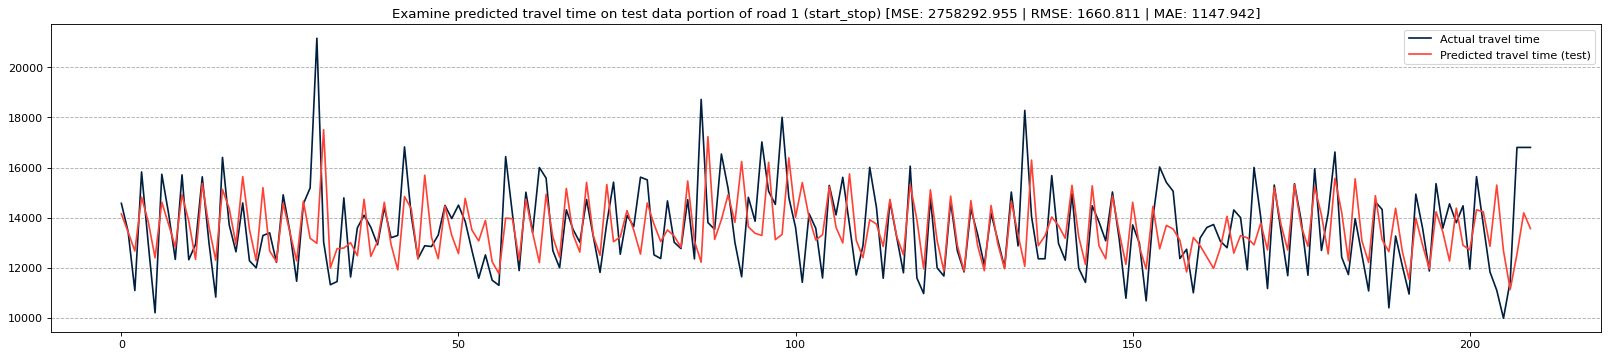

time : 6
MSE : 2758292.954913108 || RMSE : 1660.8109329219592 || MAE : 1147.9424568505112


In [34]:
result = []
for idx in range(len(dataset_train)):
    # model = ConvLSTM_Traveltime(1, 32, 3, 1, 1)
    # model = CNN_LSTM()
    model = LSTM()
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train[idx], dataset_val[idx], model, cfg, idx, 0)

    mse, rmse, mae = eval(dataset_test[idx], data_date_y_test_list[idx], split_val_index_list[idx], scaler_list[idx], model, cfg, f"cnn_lstm_time_{idx}_{0}", True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
    })

report = pd.DataFrame(result)

In [35]:
report['rmse'].mean()

2574.353489575066

In [36]:
report['mae'].mean()

1931.7404966120648